# Training a Foreground Segmentation Tool with DINOv3

In this tutorial, we will train a linear foreground segmentation model using DINOv3 features.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [1]:
import io
import os
import pickle
import tarfile
import urllib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm

DINOV3_GITHUB_LOCATION = "/home/lades/computer_vision/wesley/dino-soja/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to /home/lades/computer_vision/wesley/dino-soja/dinov3


### Model

Let's load the DINOv3 model. For this notebook, we will be using the ViT-L model, but if you have more or less hardware constraints, you can easily load any other DINOv3 model!

In [7]:
import torch

REPO_DIR = f"{DINOV3_LOCATION}"

# DINOv3 ViT models pretrained on web images
dinov3_vits16 = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights='https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vits16plus = torch.hub.load(REPO_DIR, 'dinov3_vits16plus', source='local', weights='https://dinov3.llamameta.net/dinov3_vits16plus/dinov3_vits16plus_pretrain_lvd1689m-4057cbaa.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vitb16 = torch.hub.load(REPO_DIR, 'dinov3_vitb16', source='local', weights='https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vitl16 = torch.hub.load(REPO_DIR, 'dinov3_vitl16', source='local', weights='https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vith16plus = torch.hub.load(REPO_DIR, 'dinov3_vith16plus', source='local', weights='https://dinov3.llamameta.net/dinov3_vith16plus/dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vit7b16 = torch.hub.load(REPO_DIR, 'dinov3_vit7b16', source='local', weights='https://dinov3.llamameta.net/dinov3_vit7b16/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')

# DINOv3 ConvNeXt models pretrained on web images
#dinov3_convnext_tiny = torch.hub.load(REPO_DIR, 'dinov3_convnext_tiny', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_tiny/dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_convnext_small = torch.hub.load(REPO_DIR, 'dinov3_convnext_small', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_small/dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_convnext_base = torch.hub.load(REPO_DIR, 'dinov3_convnext_base', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_base/dinov3_convnext_base_pretrain_lvd1689m-801f2ba9.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_convnext_large = torch.hub.load(REPO_DIR, 'dinov3_convnext_large', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_large/dinov3_convnext_large_pretrain_lvd1689m-61fa432d.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')

# DINOv3 ViT models pretrained on satellite imagery
dinov3_vitl16 = torch.hub.load(REPO_DIR, 'dinov3_vitl16', source='local', weights='https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vit7b16 = torch.hub.load(REPO_DIR, 'dinov3_vit7b16', source='local', weights='https://dinov3.llamameta.net/dinov3_vit7b16/dinov3_vit7b16_pretrain_sat493m-a6675841.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')

In [2]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITL

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local",
    weights="https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725"
)
model.cuda()

# Usar normalização para imagens de satélite
SATELLITE_MEAN = (0.430, 0.411, 0.296)
SATELLITE_STD = (0.213, 0.156, 0.143)

### Data
Now that we have the model set up, let's load the training data. It consists of:

- images in `jpg` format:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz
```

- and segmentation masks stored as alpha channels in `png` files:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz
```

In total, there are 9 training image / mask pairs.


In [3]:

def visualize_label_processing(label_image: Image.Image, index: int = 0):
    """Visualiza o processamento da label"""
    processed_label = process_label_for_soja(label_image)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(label_image)
    plt.title(f'Original Label {index}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(processed_label, cmap='gray')
    plt.title('Processed (Binary)')
    plt.axis('off')
    
    # Mostrar estatísticas
    original_array = np.array(label_image)
    processed_array = np.array(processed_label)
    
    plt.subplot(1, 3, 3)
    unique_colors = np.unique(original_array.reshape(-1, 3), axis=0)
    plt.text(0.1, 0.8, f'Unique colors in original:', fontsize=10, transform=plt.gca().transAxes)
    for i, color in enumerate(unique_colors[:10]):  # Mostrar até 10 cores
        plt.text(0.1, 0.7-i*0.08, f'RGB{tuple(color)}', fontsize=8, transform=plt.gca().transAxes)
    
    foreground_pixels = np.sum(processed_array == 255)
    background_pixels = np.sum(processed_array == 0)
    plt.text(0.1, 0.3, f'Foreground pixels: {foreground_pixels}', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.2, f'Background pixels: {background_pixels}', fontsize=10, transform=plt.gca().transAxes)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
from pathlib import Path

def load_local_dataset(dataset_root: str):
    """Carrega imagens RGB e labels do dataset local"""
    dataset_path = Path(dataset_root)
    
    images = []
    labels = []
    
    # Carregar dados de treino e validação
    for split in ['train', 'val']:
        rgb_path = dataset_path / "rgb" / split
        label_path = dataset_path / "labels" / split
        
        # Verificar se os diretórios existem
        if not rgb_path.exists():
            print(f"Aviso: Diretório {rgb_path} não encontrado")
            continue
        if not label_path.exists():
            print(f"Aviso: Diretório {label_path} não encontrado")
            continue
        
        # Obter lista de arquivos RGB
        rgb_files = sorted(list(rgb_path.glob("*.png")) + list(rgb_path.glob("*.jpg")))
        
        print(f"Encontrados {len(rgb_files)} arquivos RGB em {split}")
        
        for rgb_file in rgb_files:
            # Encontrar label correspondente substituindo a extensão de .jpg por .png
            label_file = label_path / rgb_file.name
            label_file = label_file.with_suffix('.png' if rgb_file.suffix.lower() == '.jpg' else rgb_file.suffix)

            if label_file.exists():
                try:
                    # Carregar imagem RGB
                    rgb_image = Image.open(rgb_file).convert('RGB')
                    images.append(rgb_image)
                    
                    # Carregar label RGB (manter as cores originais)
                    label_image = Image.open(label_file).convert('RGB')
                    labels.append(label_image)
                    
                except Exception as e:
                    print(f"Erro ao carregar {rgb_file}: {e}")
            else:
                print(f"Label não encontrada para {rgb_file.name}")
    
    return images, labels

DATASET_ROOT = "/home/lades/computer_vision/wesley/dataset/daninhas_multiclasse2"
images, labels = load_local_dataset(DATASET_ROOT)
n_images = len(images)
print(f"{n_images} imagens e labels foram carregadas do dataset {DATASET_ROOT.split('/')[-1]}")

Encontrados 764 arquivos RGB em train
Encontrados 191 arquivos RGB em val
955 imagens e labels foram carregadas do dataset daninhas_multiclasse2


In [6]:
import os

def process_label_for_soja(label_image: Image.Image) -> Image.Image:
    """
    Processa labels RGB do dataset de soja/daninhas
    - Fundo preto (0,0,0) = background
    - Branco (255,255,255) = background 
    - Vermelho, azul, amarelo, verde = foreground (daninhas)
    """
    # Converter para array numpy
    label_array = np.array(label_image)
    
    # Verificar se é uma imagem RGB
    if len(label_array.shape) == 3 and label_array.shape[2] == 3:
        # Detectar pixels de background (preto e branco)
        black_pixels = np.all(label_array == [0, 0, 0], axis=2)
        white_pixels = np.all(label_array == [255, 255, 255], axis=2) 
        
        # Background = preto OU branco
        background_mask = black_pixels | white_pixels
        
        # Foreground = qualquer coisa que não seja background
        foreground_mask = ~background_mask
        
        # Criar máscara binária: 0 = background, 255 = foreground
        binary_mask = foreground_mask.astype(np.uint8) * 255
    else:
        # Fallback para imagens grayscale
        binary_mask = (label_array > 0).astype(np.uint8) * 255
    
    return Image.fromarray(binary_mask)


In [10]:
PATCH_SIZE = 16
IMAGE_SIZE = 256

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

In [11]:
def extract_features_and_labels_soja(images, labels, model, n_layers):
    """Extrai features e labels processadas para o dataset de soja"""
    xs = []
    ys = []
    image_index = []
    
    # Usar normalização para imagens de satélite (melhor para agricultura)
    SATELLITE_MEAN = (0.430, 0.411, 0.296)
    SATELLITE_STD = (0.213, 0.156, 0.143)
    
    with torch.inference_mode():
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            for i in tqdm(range(len(images)), desc="Processing soja images"):
                # Processar label RGB para máscara binária
                label_processed = process_label_for_soja(labels[i])
                mask_i_resized = resize_transform(label_processed)
                mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().view(-1).detach().cpu()
                
                # Normalizar valores para [0,1]
                mask_i_quantized = mask_i_quantized / 255.0
                ys.append(mask_i_quantized)
                
                # Processar imagem RGB
                image_i = images[i].convert('RGB')
                image_i_resized = resize_transform(image_i)
                image_i_resized = TF.normalize(image_i_resized, mean=SATELLITE_MEAN, std=SATELLITE_STD)
                image_i_resized = image_i_resized.unsqueeze(0).cuda()

                # Extrair features
                feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
                dim = feats[-1].shape[1]
                xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

                image_index.append(i * torch.ones(ys[-1].shape))

    return xs, ys, image_index

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

# Usar a nova função de extração
xs, ys, image_index = extract_features_and_labels_soja(images, labels, model, n_layers)

Processing soja images: 100%|██████████| 955/955 [00:28<00:00, 32.95it/s]


In [12]:
# Concatenar tensores
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)

# Filtrar patches com labels claros
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size:", xs.shape)
print("Label matrix of size:", ys.shape)
print(f"Foreground patches: {torch.sum(ys > 0.5).item()}")
print(f"Background patches: {torch.sum(ys < 0.5).item()}")

# Treinar classificador
clf = LogisticRegression(random_state=0, C=0.1, max_iter=100000, verbose=2)
clf.fit(xs.numpy(), (ys > 0).long().numpy())

# Salvar modelo treinado
model_path = "soja_foreground_classifier.pkl"
with open(model_path, "wb") as f:
    pickle.dump(clf, f)

print(f"Modelo salvo em: {model_path}")

Design matrix of size: torch.Size([244480, 1024])
Label matrix of size: torch.Size([244480])
Foreground patches: 0
Background patches: 244480
Modelo salvo em: soja_foreground_classifier.pkl


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


In [ ]:
# Atualizar a célula de visualização
data_index = 0  # Usar índice 0 primeiro para verificar

if data_index < len(images) and data_index < len(labels):
    print(f"Showing image / mask at index {data_index}:")

    image = images[data_index]
    label_original = labels[data_index] 
    
    # Processar a label para criar máscara binária
    mask_processed = process_label_for_soja(label_original)
    
    # Visualizar o processamento
    visualize_label_processing(label_original, data_index)
    
    # Criar composições para visualização
    # Como a label original é RGB, vamos usá-la diretamente
    data_to_show = [image, label_original, mask_processed]
    data_labels = ["Original Image", "Color Label", "Binary Mask"]

    plt.figure(figsize=(15, 5), dpi=300)
    for i in range(len(data_to_show)):
        plt.subplot(1, len(data_to_show), i + 1)
        if i == 2:  # Máscara binária
            plt.imshow(data_to_show[i], cmap='gray')
        else:
            plt.imshow(data_to_show[i])
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print(f"Índice {data_index} fora do alcance. Dataset tem {len(images)} imagens.")

Let's, for example, visualize the first image / mask pair:

Showing image / mask at index 2:


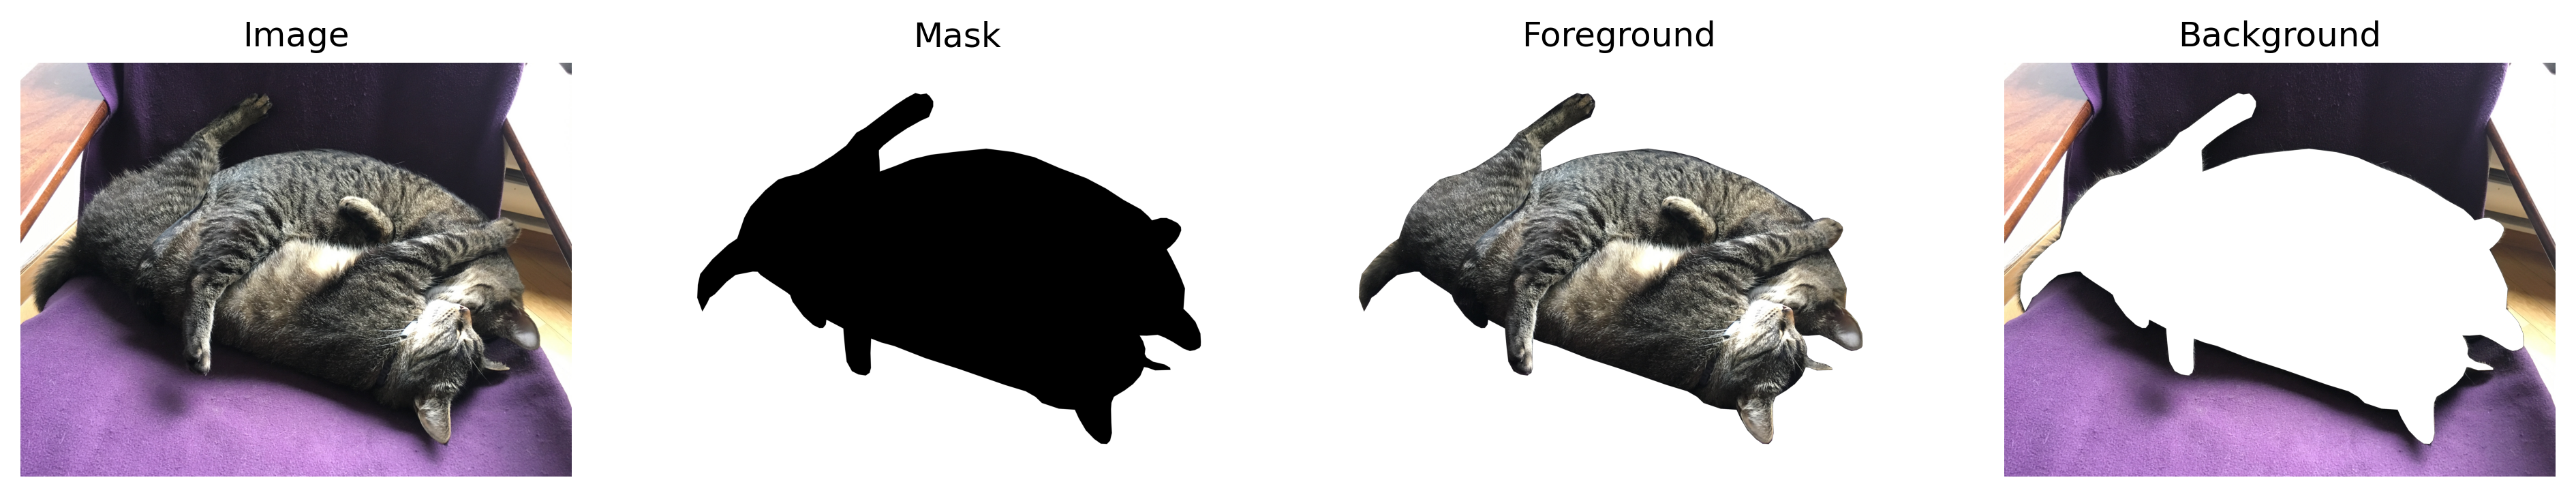

In [13]:
data_index = 2

print(f"Showing image / mask at index {data_index}:")

image = images[data_index]
mask = labels[data_index]
foreground = Image.composite(image, mask, mask)
mask_bg_np = np.copy(np.array(mask))
mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
mask_bg = Image.fromarray(mask_bg_np)
background = Image.composite(image, mask_bg, mask_bg)

data_to_show = [image, mask, foreground, background]
data_labels = ["Image", "Mask", "Foreground", "Background"]

plt.figure(figsize=(16, 4), dpi=300)
for i in range(len(data_to_show)):
    plt.subplot(1, len(data_to_show), i + 1)
    plt.imshow(data_to_show[i])
    plt.axis('off')
    plt.title(data_labels[i], fontsize=12)
plt.show()

### Building Per-Patch Label Map

Since our models run with a patch size of 16, we have to quantize the ground truth to a 16x16 pixels grid. To achieve this, we define:
- the resize transform to resize an image such that it aligns well with the 16x16 grid;
- a uniform 16x16 conv layer as a [box blur filter](https://en.wikipedia.org/wiki/Box_blur) with stride equal to the patch size.

Let's, for example, visualize the first mask before and after quantization:

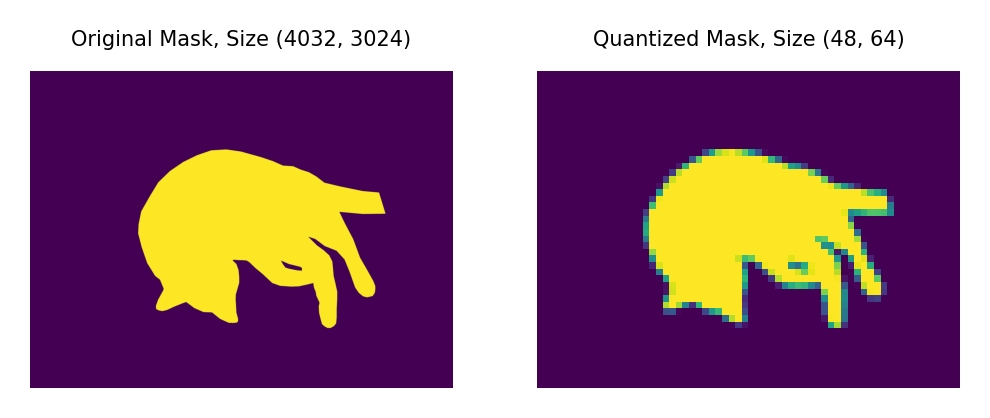

In [15]:
mask_0 = labels[0].split()[-1]
mask_0_resized = resize_transform(mask_0)
with torch.no_grad():
    mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(mask_0)
plt.axis('off')
plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)
plt.subplot(1, 2, 2)
plt.imshow(mask_0_quantized)
plt.axis('off')
plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)
plt.show()

### Extracting Features and Labels for All the Images
Now we will loop over the 9 training images, and extract for each image the patch labels, as well as the patch features. That involves running the dense feature extraction of our model with :

```
with torch.no_grad():        
    feats = model.get_intermediate_layers(img, n=range(n_layers), reshape=True, norm=True)
    dim = feats[-1].shape[1]
    xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
```

In [16]:
xs = []
ys = []
image_index = []

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for i in tqdm(range(n_images), desc="Processing images"):
            # Loading the ground truth
            mask_i = labels[i].split()[-1]
            mask_i_resized = resize_transform(mask_i)
            mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().view(-1).detach().cpu()
            ys.append(mask_i_quantized)
            # Loading the image data 
            image_i = images[i].convert('RGB')
            image_i_resized = resize_transform(image_i)
            image_i_resized = TF.normalize(image_i_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_i_resized = image_i_resized.unsqueeze(0).cuda()

            feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

            image_index.append(i * torch.ones(ys[-1].shape))


# Concatenate all lists into torch tensors 
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)

# keeping only the patches that have clear positive or negative label
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size : ", xs.shape)
print("Label matrix of size : ", ys.shape)

Processing images:   0%|          | 0/9 [00:00<?, ?it/s]

Processing images: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

Design matrix of size :  torch.Size([23604, 1024])
Label matrix of size :  torch.Size([23604])


### Training a Classifier and Model Selection
We computed the features, let's now train a classifier! Our data is very strongly correlated image-by-image. Therefore, to do proper model selection, we can't simply split the data in an IID way. We need to do something a bit smarter. We will do leave-one-out, and consecutively exclude each image as a validation set. 
We'll try 8 values of C ranging from 1e-7 to 1e-0. 

For each value of C and each image, we plot the precision-recall curve of the classifier, and report the mAP (area under the PR curve).

validation using image_01.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


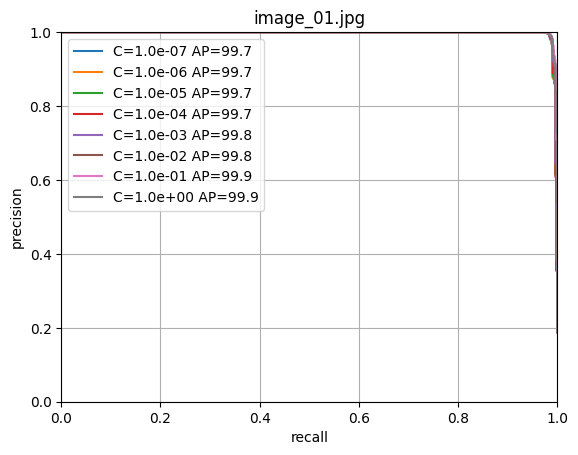

validation using image_02.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


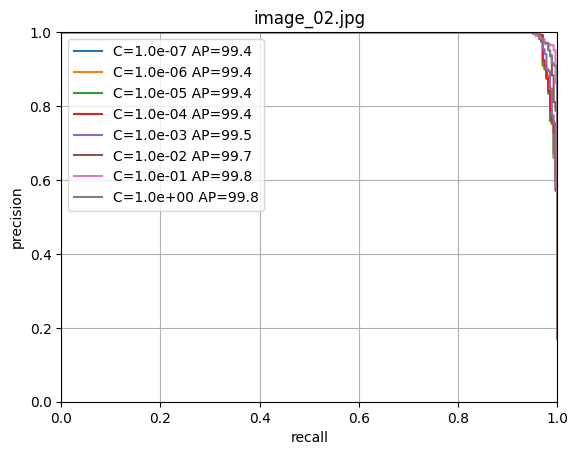

validation using image_03.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


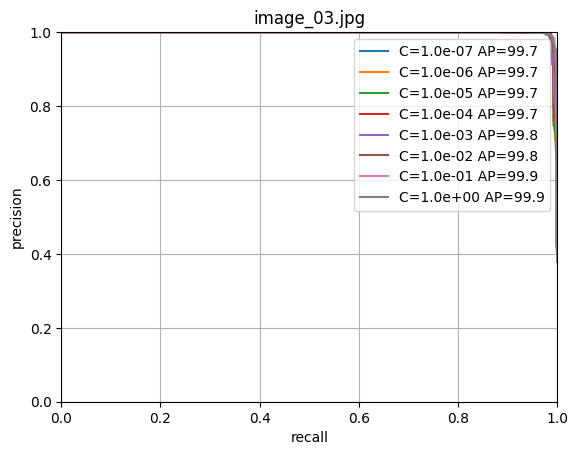

validation using image_04.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


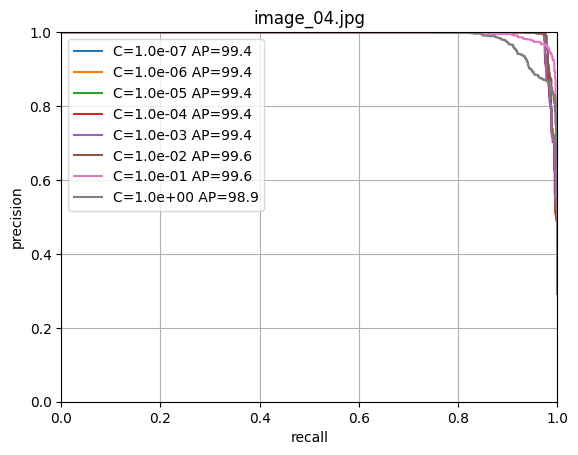

validation using image_05.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


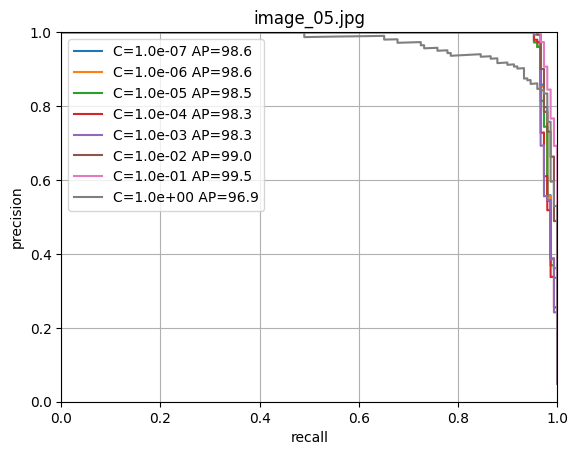

validation using image_06.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


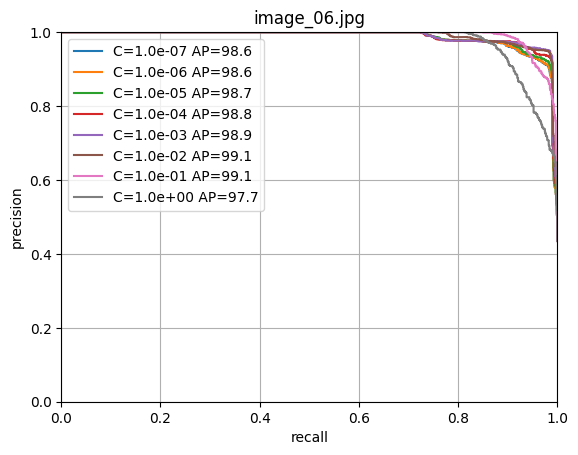

validation using image_07.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


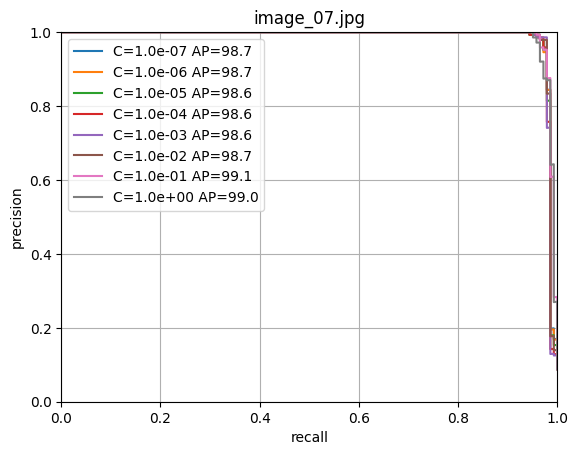

validation using image_08.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


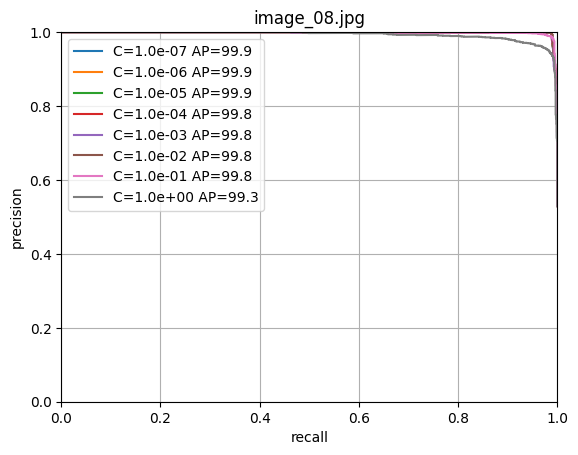

validation using image_09.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


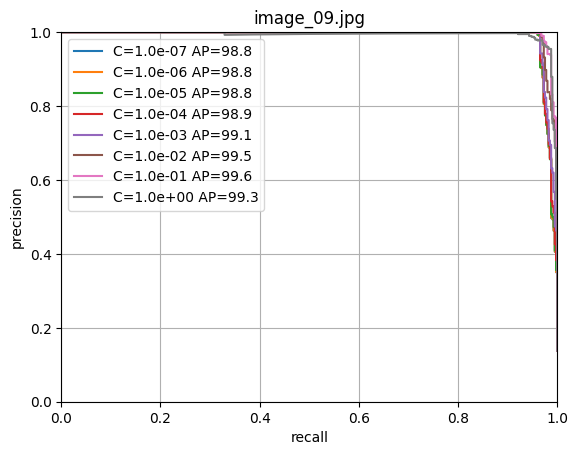

In [17]:
cs = np.logspace(-7, 0, 8)
scores = np.zeros((n_images, len(cs)))

for i in range(n_images):
    # We use leave-one-out so train will be all but image i, val will be image i
    print('validation using image_{:02d}.jpg'.format(i+1))
    train_selection = image_index != float(i)
    fold_x = xs[train_selection].numpy()
    fold_y = (ys[train_selection] > 0).long().numpy()
    val_x = xs[~train_selection].numpy()
    val_y = (ys[~train_selection] > 0).long().numpy()

    plt.figure()
    for j, c in enumerate(cs):
        print("training logisitic regression with C={:.2e}".format(c))
        clf = LogisticRegression(random_state=0, C=c, max_iter=10000).fit(fold_x, fold_y)
        output = clf.predict_proba(val_x)
        precision, recall, thresholds = precision_recall_curve(val_y, output[:, 1])
        s = average_precision_score(val_y, output[:, 1])
        scores[i, j] = s
        plt.plot(recall, precision, label='C={:.1e} AP={:.1f}'.format(c, s*100))

    plt.grid()
    plt.xlabel('recall')
    plt.title('image_{:02d}.jpg'.format(i+1))
    plt.ylabel('precision')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    plt.show()


### Choosing the Best C
Now, let's have a look at which value of C works best on average. To this end we will plot the average mAP across all validation images.

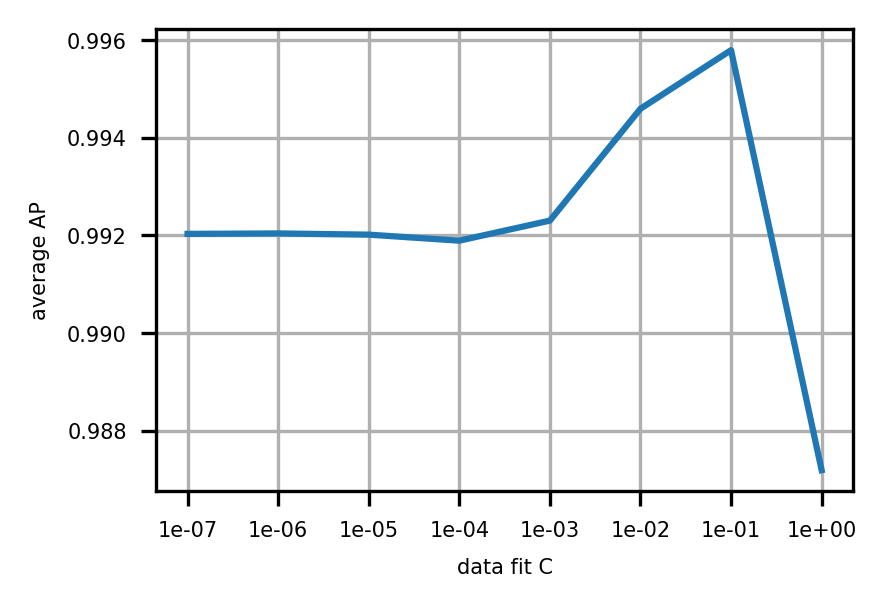

In [9]:
plt.figure(figsize=(3, 2), dpi=300)
plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
})
plt.plot(scores.mean(axis=0))
plt.xticks(np.arange(len(cs)), ["{:.0e}".format(c) for c in cs])
plt.xlabel('data fit C')
plt.ylabel('average AP')
plt.grid()
plt.show()

### Retraining with the optimal regularization
Given the above, we seem to have a winner: C=0.1. 
Let's now train a model using this optimal data-fit value. 

In [10]:
clf = LogisticRegression(random_state=0, C=0.1, max_iter=100000, verbose=2).fit(xs.numpy(), (ys > 0).long().numpy())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1025     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63610D+04    |proj g|=  1.28915D+04

At iterate    1    f=  4.15681D+03    |proj g|=  4.49281D+03

At iterate    2    f=  2.16198D+03    |proj g|=  1.74446D+03

At iterate    3    f=  1.52275D+03    |proj g|=  9.40643D+02

At iterate    4    f=  1.06750D+03    |proj g|=  4.39957D+02

At iterate    5    f=  8.16646D+02    |proj g|=  2.06895D+02

At iterate    6    f=  6.69236D+02    |proj g|=  8.85818D+01

At iterate    7    f=  5.77333D+02    |proj g|=  3.17096D+01

At iterate    8    f=  5.07922D+02    |proj g|=  1.96323D+01

At iterate    9    f=  4.79121D+02    |proj g|=  5.20827D+01

At iterate   10    f=  4.52817D+02    |proj g|=  1.09191D+01

At iterate   11    f=  4.45991D+02    |proj g|=  1.66427D+01

At iterate   12    f=  4.41202D+02    |proj g|=  1.31531D+01

At iterate   13    f=  4.3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


### Test Images and Inference 

We have a classifier, now it is time to test it! We will predict the probability of patch being foreground given an image, and then process it with a 3x3 median filter to smooth it out.

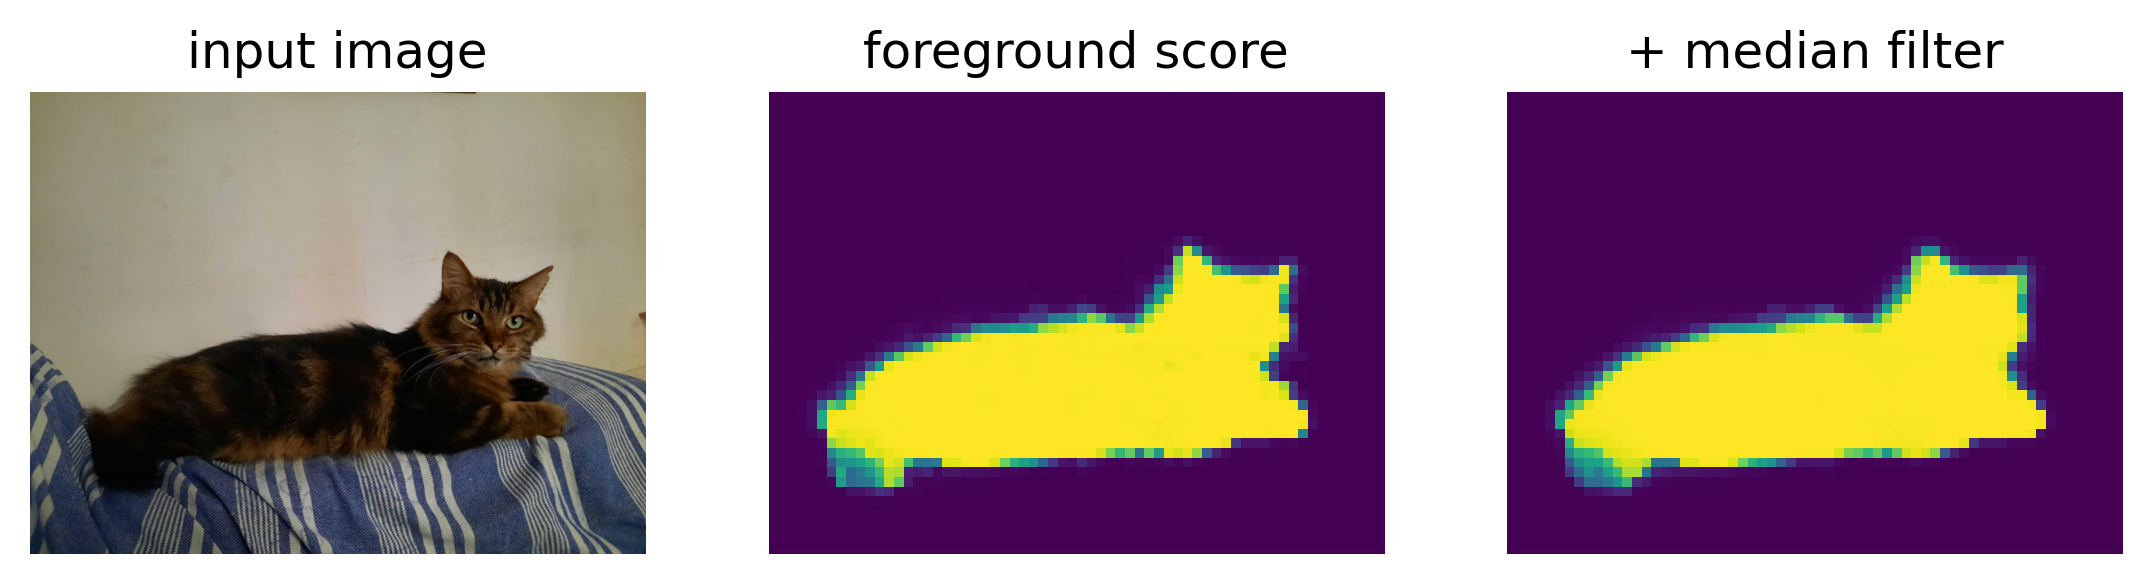

In [11]:
test_image_fpath = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/test_image.jpg"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


test_image = load_image_from_url(test_image_fpath)
test_image_resized = resize_transform(test_image)
test_image_normalized = TF.normalize(test_image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(test_image_normalized.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

h_patches, w_patches = [int(d / PATCH_SIZE) for d in test_image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.figure(figsize=(9, 3), dpi=300)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(fg_score)
plt.title('foreground score')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

### Saving the Model for Future Use
We are nearly done, let's just save a pickle with the classifier.


In [12]:
save_root = '.'
model_path = os.path.join(save_root, "fg_classifier.pkl")
with open(model_path, "wb") as f:
  pickle.dump(clf, f)